In [1]:
import tidy3d
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web
import gdstk
from tidy3d.plugins.mode import ModeSolver
from tidy3d.constants import C_0


In [2]:
web.configure("82bAfpuLTl2eTtjrDCw9exK04XlTCrcWH3T0n6BfZML2YESO")

Configured successfully.


## Import the gds

In [3]:
file_loc = r'iosmfnit_v_4_1.gds'
lib_loaded = gdstk.read_gds(file_loc)

In [4]:
# Create a cell dictionary with all the cells in the file
all_cells = {c.name: c for c in lib_loaded.cells}

print("Cell names: " + ", ".join(all_cells.keys()))

Cell names: arcbo_CDNS_707951448191, arcbo_CDNS_707951448192, x_wdm_arc_CDNS_707951448195, x_wdm_circle_CDNS_707951448194, x_wdm_arc_CDNS_707951448197, x_wdm_circle_CDNS_707951448196, x_iosmf_half_CDNS_707951448193, arcbo_CDNS_707951448198, arcbo_CDNS_707951448199, iosmfnit_CDNS_707951448190, iosmfnit


In [5]:
cell_loaded = all_cells["iosmfnit"]

In [6]:
base = gdstk.rectangle(
    cell_loaded.bounding_box()[0],
    cell_loaded.bounding_box()[1],
    layer=0,  # needs to be layer 0 to work with iosmifnit_stack.stack 
)

cell_loaded.add(base)

# Make the stack

In [7]:
import iosmfnit_stack

In [8]:
# central frequency
wvl_um = 1.310
freq0 = C_0 / wvl_um
wvl_um_low = 1.29
wvl_um_high = 1.33
freq_low = C_0 / wvl_um_high
freq_high = C_0 / wvl_um_low
fwidth = freq_high - freq_low

In [9]:
dilation = 0.0
sidewall_angle = 87
reference_plane = "bottom"

In [10]:
def draw_top(cell, z0=-400, stack=iosmfnit_stack.stack):
    structures = []
    for key, val in stack.items():
        if key == 'Nit WG':
            z0 = z0 - iosmfnit_stack.stack['ILD Oxide']['thick']
            geo = td.Geometry.from_gds(cell, gds_layer=val['layer'], axis=2, 
                                   slab_bounds=(z0, z0 + val['thick']), reference_plane=reference_plane)
            z0 = z0 + val['thick'] + 0.025
        else:
            geo = td.Geometry.from_gds(cell, gds_layer=val['layer'], axis=2, 
                                   slab_bounds=(z0, z0 + val['thick']), reference_plane=reference_plane)
            z0 = z0 + val['thick']
        structure = td.Structure(geometry=geo, medium=td.Medium(permittivity = val['index']**2))
        structures.append(structure)
    return structures

In [11]:
structures = draw_top(cell_loaded)

# Draw the simulation

[00:27:05] WARNING: A bound of Simulation.structures[5] was detected as being   
           within the simulation PML. We recommend extending structures to      
           infinity or completely outside of the simulation PML to avoid        
           unexpected effects when the structures are not translationally       
           invariant within the PML.                                            

           WARNING: Suppressed 1 WARNING message.                               

Total number of grid points (millions): 8.6e+02


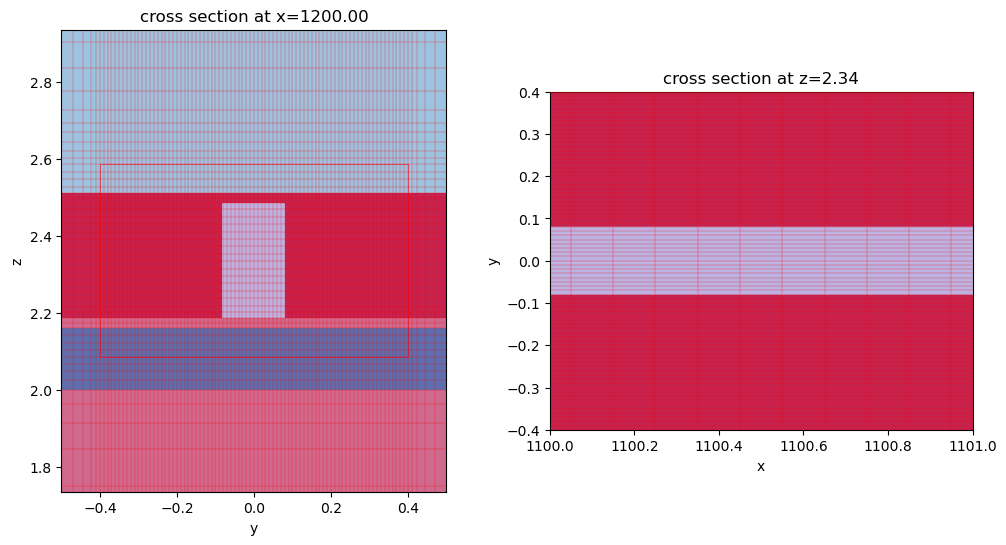

In [12]:
# Simulation size along propagation direction
sim_length_x = 847
sim_length_y = 60

# Spacing between waveguides and PML
pml_spacing = 1
sim_size = (
    sim_length_x,
    sim_length_y,
    15,
)
fine_grid_sim_size = (
    sim_length_x,
    0.8,
    0.5,
)

center = (1001.5 + 848.5/2, 0, 2.186 + (0.3/2))

refine_box = td.MeshOverrideStructure(
  geometry=td.Box(
    center=center,
    size=fine_grid_sim_size),
    dl = [100e-3, 10e-3, 20e-3]
)

grid_spec_fine = td.GridSpec(
      grid_x = td.AutoGrid(min_steps_per_wvl=6),
      grid_y = td.AutoGrid(min_steps_per_wvl=6), 
      grid_z = td.AutoGrid(min_steps_per_wvl=6),
      wavelength=wvl_um,
      override_structures=[refine_box]
      )

# Plot simulation and overlay grid in the yz and xy planes
def plot_sim_grid(sim):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    sim.plot(x=1200.0, ax=ax[0])
    sim.plot_grid(x=1200.0, ax=ax[0], lw=0.4, colors="r")
    ax[0].set_xlim(-0.5, 0.5)
    ax[0].set_ylim(center[2] - 0.6, center[2] + 0.6)
    sim.plot(z=center[2], ax=ax[1])
    sim.plot_grid(z=center[2], ax=ax[1], lw=0.4, colors="r")
    ax[1].set_xlim(1100, 1101)
    ax[1].set_ylim(-0.4, 0.4)
    print(f"Total number of grid points (millions): {sim.num_cells / 1e6:1.2}")

    return ax

# grid size in each direction
dl = 0.020

### Initialize and visualize simulation ###
sim = td.Simulation(
    center=center,
    size=sim_size,
    grid_spec=grid_spec_fine,
    structures=structures,
    run_time=20e-12,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
)

ax = plot_sim_grid(sim)

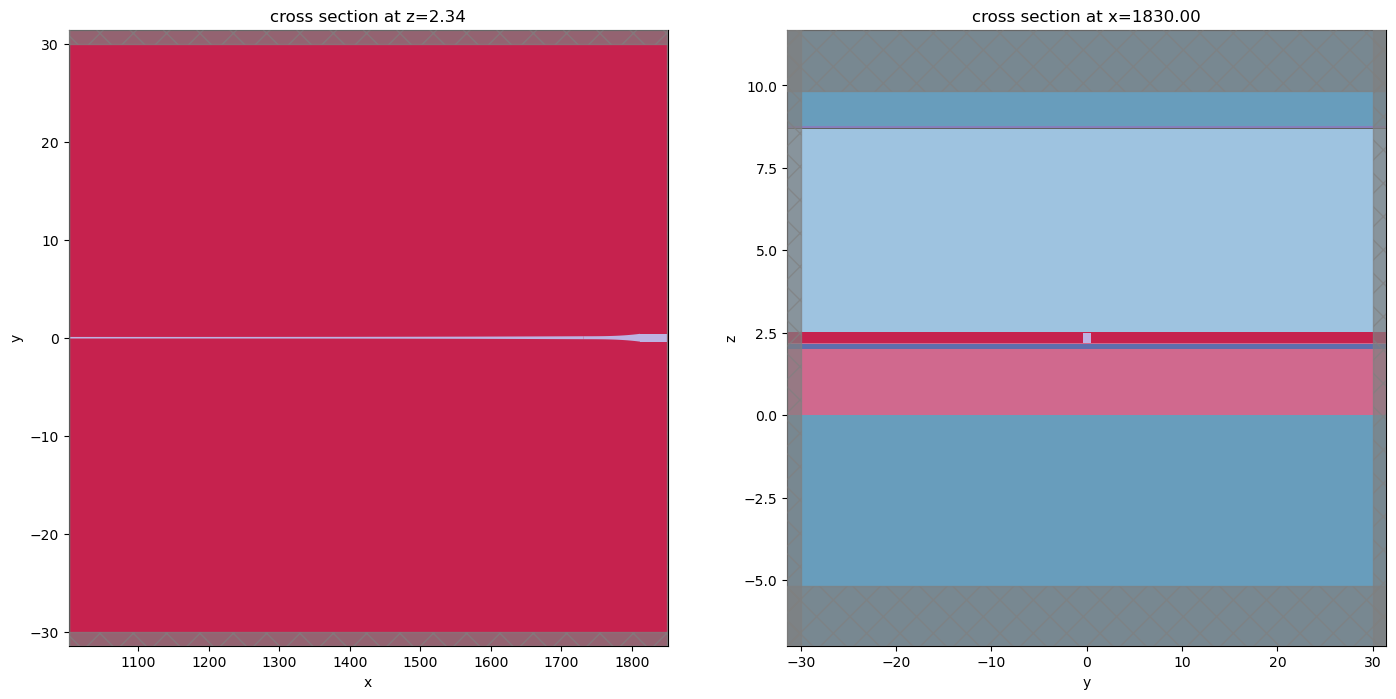

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 8))

sim.plot(z=sim.center[-1], lw=1, edgecolor="k", ax=ax1)
sim.plot(x=1001.5 + 848.5 - 20, lw=1, edgecolor="k", ax=ax2)

ax1.set_aspect(12)
ax2.set_aspect(8)

# ax1.set_ylim([-3, 3])
# _ = ax2.set_ylim([sim.center[-1] - .2, sim.center[-1] + .2])
ax1.set_aspect('auto')
ax2.set_aspect('auto')

## Solve for mode at the beginning of the structure

In [14]:
mode_spec = td.ModeSpec(
    num_modes=3,
    target_neff=2.,
)

num_freqs = 11
f0_ind = num_freqs // 2
freqs = np.linspace(freq0 - fwidth / 2, freq0 + fwidth / 2, num_freqs)

plane = td.Box(center=(1001.5 + 1, 0., 2.186 + (0.3/2)), size=(0, 10, 3.5))

mode_solver = ModeSolver(
    simulation=sim,
    plane=plane,
    mode_spec=mode_spec,
    freqs=freq0,
)
mode_data = mode_solver.solve()

           WARNING: Use the remote mode solver with subpixel averaging for      
           better accuracy through 'tidy3d.plugins.mode.web.run(...)'.          

[00:27:06] WARNING: Mode field at frequency index 0, mode index 0 does not decay
           at the plane boundaries.                                             

           WARNING: Mode field at frequency index 0, mode index 1 does not decay
           at the plane boundaries.                                             

           WARNING: A bound of Simulation.structures[5] was detected as being   
           within the simulation PML. We recommend extending structures to      
           infinity or completely outside of the simulation PML to avoid        
           unexpected effects when the structures are not translationally       
           invariant within the PML.                                            

           WARNING: Suppressed 1 WARNING message.                               

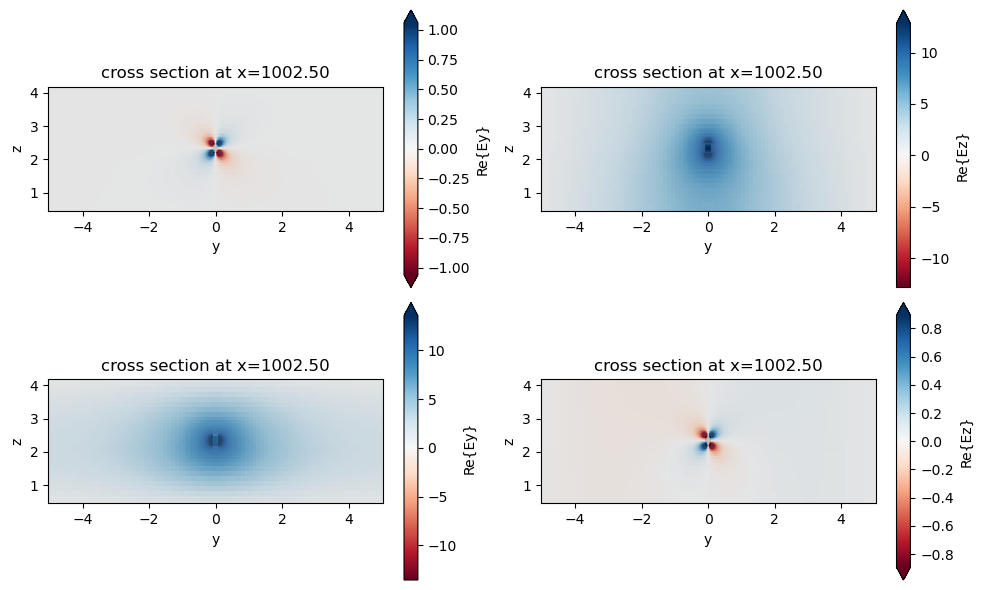

In [15]:
f, axs = plt.subplots(2, 2, tight_layout=False, figsize=(10, 6))
mode_solver.plot_field("Ey", "real", mode_index=0, f=freq0, ax=axs[0,0])
mode_solver.plot_field("Ez", "real", mode_index=0, f=freq0, ax=axs[0,1])
mode_solver.plot_field("Ey", "real", mode_index=2, f=freq0, ax=axs[1,0])
mode_solver.plot_field("Ez", "real", mode_index=2, f=freq0, ax=axs[1,1])
plt.show()

From the above, it appears we should select mode `2` for launching.

## Solve for mode near end of structure

In [16]:
mode_spec = td.ModeSpec(
    num_modes=3,
    target_neff=2.,
)

num_freqs = 11
f0_ind = num_freqs // 2
freqs = np.linspace(freq0 - fwidth / 2, freq0 + fwidth / 2, num_freqs)

plane = td.Box(center=(1001.5 + 848.5 - 2, 0., 2.186 + (0.3/2)), size=(0, 10, 3.5))

mode_solver = ModeSolver(
    simulation=sim,
    plane=plane,
    mode_spec=mode_spec,
    freqs=freq0,
)
mode_data = mode_solver.solve()

[00:27:08] WARNING: Mode field at frequency index 0, mode index 2 does not decay
           at the plane boundaries.                                             

           WARNING: A bound of Simulation.structures[5] was detected as being   
           within the simulation PML. We recommend extending structures to      
           infinity or completely outside of the simulation PML to avoid        
           unexpected effects when the structures are not translationally       
           invariant within the PML.                                            

           WARNING: Suppressed 1 WARNING message.                               

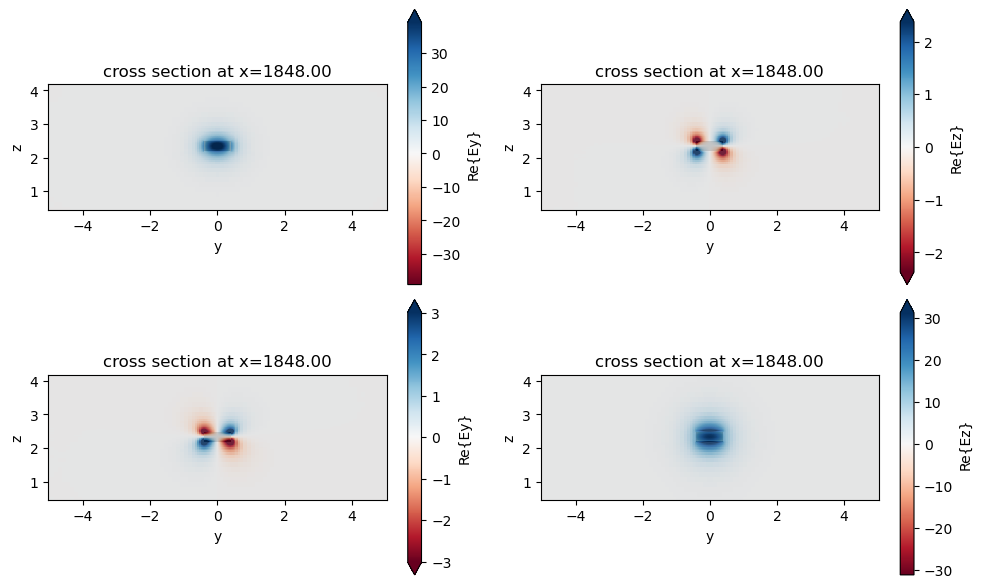

In [17]:
f, axs = plt.subplots(2, 2, tight_layout=False, figsize=(10, 6))
mode_solver.plot_field("Ey", "real", mode_index=0, f=freq0, ax=axs[0,0])
mode_solver.plot_field("Ez", "real", mode_index=0, f=freq0, ax=axs[0,1])
mode_solver.plot_field("Ey", "real", mode_index=1, f=freq0, ax=axs[1,0])
mode_solver.plot_field("Ez", "real", mode_index=1, f=freq0, ax=axs[1,1])
plt.show()

In [18]:
mode_spec

ModeSpec(num_modes=3, target_neff=2.0, num_pml=(0, 0), filter_pol=None, angle_theta=0.0, angle_phi=0.0, precision='single', bend_radius=None, bend_axis=None, track_freq='central', group_index_step=False, type='ModeSpec')

Clearly for the end of the structure, we should select mode `0`.

# FDTD preparation

In [19]:
num_freqs = 20
f0_ind = num_freqs // 2
freqs = np.linspace(freq0 - fwidth / 2, freq0 + fwidth / 2, num_freqs)

In [20]:
mode_spec_source = td.ModeSpec(num_modes=3, target_neff=2.)
mode_spec_end = mode_spec_source

# add a mode source as excitation
mode_source_te = td.ModeSource(
    center=(1001.5 + 1, 0., 2.186 + (0.3/2)),
    size=(0, 10, 3.5),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec_source,
    mode_index=2,
)

mode_source_tm = td.ModeSource(
    center=(1001.5 + 1, 0., 2.186 + (0.3/2)),
    size=(0, 10, 3.5),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec_source,
    mode_index=0,
)

mode_monitor_end = td.ModeMonitor(
    center=(1001.5 + 848.5 - 2., 0, 2.186 + (0.3/2)),
    size=mode_source_te.size,
    freqs=freqs,
    mode_spec=mode_spec_end,
    name="end",
)

# add a field monitor to visualize the field distribution
field_monitor = td.FieldMonitor(
    center=sim.center, size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

[00:27:09] WARNING: Default value for the field monitor 'colocate' setting has  
           changed to 'True' in Tidy3D 2.4.0. All field components will be      
           colocated to the grid boundaries. Set to 'False' to get the raw      
           fields on the Yee grid instead.                                      

In [21]:
sio2 = td.material_library["SiO2"]["Horiba"]

In [22]:
sim.shutoff

1e-05

# Run

           WARNING: A bound of Simulation.structures[5] was detected as being   
           within the simulation PML. We recommend extending structures to      
           infinity or completely outside of the simulation PML to avoid        
           unexpected effects when the structures are not translationally       
           invariant within the PML.                                            

           WARNING: Suppressed 1 WARNING message.                               

           WARNING: A bound of Simulation.structures[5] was detected as being   
           within the simulation PML. We recommend extending structures to      
           infinity or completely outside of the simulation PML to avoid        
           unexpected effects when the structures are not translationally       
           invariant within the PML.                                            

           WARNING: Suppressed 1 WARNING message.                               

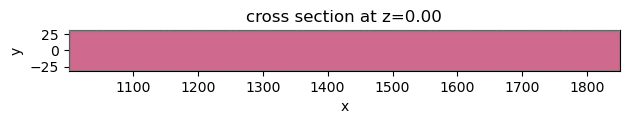

In [23]:
run_time = 20e-12  # simulation run time

# construct simulation
sim_te_pml = td.Simulation(
    center=sim.center,
    size=sim_size,
    grid_spec=grid_spec_fine,
    structures=structures,
    sources=[mode_source_te],
    monitors=[mode_monitor_end, field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    medium=sio2,
    shutoff=1e-5,
)

sim_tm_pml = td.Simulation(
    center=sim.center,
    size=sim_size,
    grid_spec=grid_spec_fine,
    structures=structures,
    sources=[mode_source_tm],
    monitors=[mode_monitor_end, field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    medium=sio2,
    shutoff=1e-5,
)

# plot simulation
sim_te_pml.plot(z=0)
plt.show()

In [24]:
sims = {
    "iosmfnit_te": sim_te_pml,
    "iosmfnit_tm": sim_tm_pml,
}

batch = web.Batch(simulations=sims, verbose=True)
batch.estimate_cost()

[00:27:10] Created task 'iosmfnit_te' with task_id                              
           'fdve-85297a87-a2fa-42a8-82f1-d44f050ab078'.

           View task using web UI at                                            
           ]8;id=840337;https://tidy3d.simulation.cloud/workbench?taskId=fdve-85297a87-a2fa-42a8-82f1-d44f050ab078\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=908614;https://tidy3d.simulation.cloud/workbench?taskId=fdve-85297a87-a2fa-42a8-82f1-d44f050ab078\taskId]8;;\]8;id=840337;https://tidy3d.simulation.cloud/workbench?taskId=fdve-85297a87-a2fa-42a8-82f1-d44f050ab078\=]8;;\]8;id=324883;https://tidy3d.simulation.cloud/workbench?taskId=fdve-85297a87-a2fa-42a8-82f1-d44f050ab078\fdve]8;;\]8;id=840337;https://tidy3d.simulation.cloud/workbench?taskId=fdve-85297a87-a2fa-42a8-82f1-d44f050ab078\-85297a87-a2fa-]8;;\
           ]8;id=840337;https://tidy3d.simulation.cloud/workbench?taskId=fdve-85297a87-a2fa-42a8-82f1-d44f050ab078\42a8-82f1-d44f050ab078']8;;\.

Output()

[00:27:11] Created task 'iosmfnit_tm' with task_id                              
           'fdve-5c3fd56a-69fa-4eb5-967e-006e00115577'.

           View task using web UI at                                            
           ]8;id=106249;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c3fd56a-69fa-4eb5-967e-006e00115577\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=467992;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c3fd56a-69fa-4eb5-967e-006e00115577\taskId]8;;\]8;id=106249;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c3fd56a-69fa-4eb5-967e-006e00115577\=]8;;\]8;id=166201;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c3fd56a-69fa-4eb5-967e-006e00115577\fdve]8;;\]8;id=106249;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c3fd56a-69fa-4eb5-967e-006e00115577\-5c3fd56a-69fa-]8;;\
           ]8;id=106249;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5c3fd56a-69fa-4eb5-967e-006e00115577\4eb5-967e-006e00115577']8;;\.

Output()

269.7237139120988

In [25]:
batch_results = batch.run(path_dir="data/iosmfnit_10_41_v0p1")

[00:27:14] Started working on Batch.

[00:27:16] Maximum FlexCredit cost: 269.724 for the whole batch. Use            
           'Batch.real_cost()' to get the billed FlexCredit cost after the Batch
           has completed.

Output()

[01:14:28] Batch complete.

In [26]:
batch.real_cost()

           WARNING: Billed FlexCredit for task                                  
           'fdve-85297a87-a2fa-42a8-82f1-d44f050ab078' is not available. If the 
           task has been successfully run, it should be available shortly.      

           WARNING: Billed FlexCredit for task                                  
           'fdve-5c3fd56a-69fa-4eb5-967e-006e00115577' is not available. If the 
           task has been successfully run, it should be available shortly.      

Output()

[01:14:58] loading SimulationData from                                          
           data/iosmfnit_10_41_v0p1/fdve-85297a87-a2fa-42a8-82f1-d44f050ab078.hd
           f5

           WARNING: A bound of Simulation.structures[5] was detected as being   
           within the simulation PML. We recommend extending structures to      
           infinity or completely outside of the simulation PML to avoid        
           unexpected effects when the structures are not translationally       
           invariant within the PML.                                            

           WARNING: Suppressed 1 WARNING message.                               

Output()

[01:15:29] loading SimulationData from                                          
           data/iosmfnit_10_41_v0p1/fdve-5c3fd56a-69fa-4eb5-967e-006e00115577.hd
           f5

           WARNING: A bound of Simulation.structures[5] was detected as being   
           within the simulation PML. We recommend extending structures to      
           infinity or completely outside of the simulation PML to avoid        
           unexpected effects when the structures are not translationally       
           invariant within the PML.                                            

           WARNING: Suppressed 1 WARNING message.                               

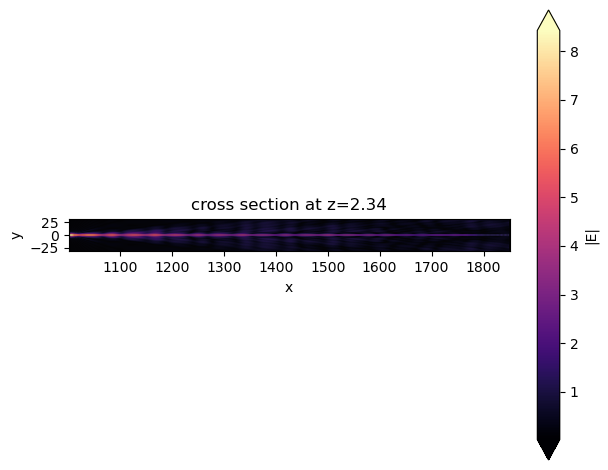

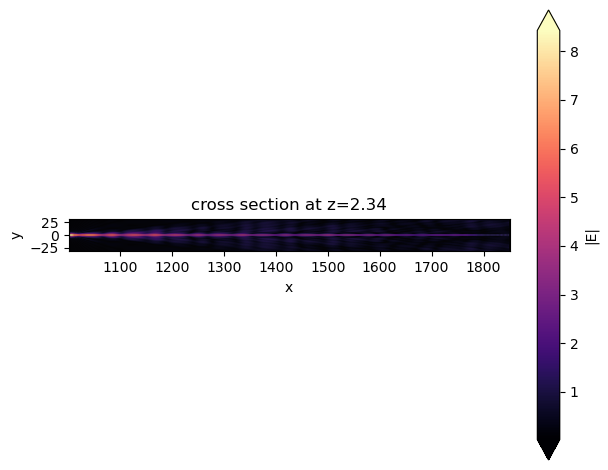

In [27]:
iosmfnit_te_data = batch_results["iosmfnit_te"]
iosmfnit_tm_data = batch_results["iosmfnit_tm"]
iosmfnit_te_data.plot_field(field_monitor_name="field", field_name="E", val="abs")
plt.show()
iosmfnit_te_data.plot_field(field_monitor_name="field", field_name="E", val="abs")
plt.show()

Text(0, 0.5, 'Transmission (dB)')

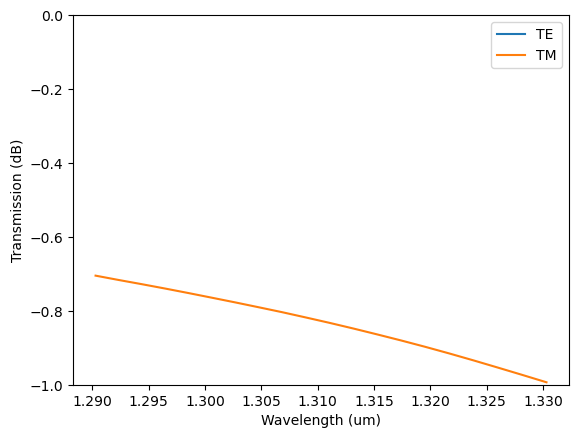

In [30]:
amp_te = iosmfnit_te_data["end"].amps.sel(mode_index=0, direction="+")
T = np.abs(amp_te) ** 2
plt.plot(C_0/iosmfnit_tm_data["end"].amps['f'].values, 10*np.log10(T), label='TE')
amp_tm = iosmfnit_tm_data["end"].amps.sel(mode_index=1, direction="+")
T = np.abs(amp_tm) ** 2
plt.plot(C_0/iosmfnit_tm_data["end"].amps['f'].values, 10*np.log10(T), label='TM')
plt.legend()
plt.ylim([-1,0])
plt.xlabel('Wavelength (um)')
plt.ylabel('Transmission (dB)')